# Sionna V1.1 MeshRadioMap2D Project to 2D

### General Problem Statement

Given a 3D triangle mesh where each triangle has an associated path gain value, project this mesh onto a 2D plane (e.g., XY plane), and compute a path gain field over a 2D regular grid on that plane. Each grid cell accumulates gain contributions from all triangles that overlap it, where the contribution of each triangle is weighted by its overlapping area with the cell.

### Exact Overlap Areas vs. Approximate / Sampling-Based Rasterization
To my knowledge, Exact Overlap Areas can only be done with Shapely, all other GPU based acceraltion framework did not provide such a out-of-box solution of exact overlap area calculation for any given polygon.

## Results:
- Navie approach with pruning: 3:00
- STRtree approach (STRtree on terrain mesh): 2:23
- Navie approach with pruning + Multiprocessing(20 process): 0:11
- Shapely Vectorized API: 1:23
- Navie approach with pruning + Multiprocessing(20 process) + Shapely Vectorized API + Fork: 0:05



In [1]:
# --------------------------------------------------
# Load triangle mesh from PLY file
# --------------------------------------------------
PLY_FILE = "../scenes/Boston/mesh/lidar_terrain.ply"

TRI_PATH_GAIN_FILE ="../scenes/Boston/path_gain_values.npy"

CELL_SIZE = 1  # User-defined resolution (grid cell size)


In [2]:
import trimesh
import numpy as np

mesh = trimesh.load(PLY_FILE)
assert mesh.faces.shape[1] == 3, "Mesh must be triangle-only"


triangle_path_gain_value = np.load(TRI_PATH_GAIN_FILE)
print("Total # of the triangles: ", mesh.faces.shape[0])
assert len(triangle_path_gain_value) ==  mesh.faces.shape[0], "# of triangles must be the same with # of path gain values"

Total # of the triangles:  340814


## 1. Navie Approach

O(num_triangles * num_cells)

Loop throught each triangles, check if given triangle intersect with any cells. If intersect, record the overlap area and the compute the area weighted path gain(linear).

### Optimizaztion:
- bounding box clipping and filtering.
- Check if intersects first, then calculate the intersection area.

In [3]:
%%time

import numpy as np
from shapely.geometry import Polygon, box
from tqdm import tqdm
import argparse
import os
import trimesh

mesh = trimesh.load(PLY_FILE)
triangle_colors = np.load(TRI_PATH_GAIN_FILE)
padding = 0

# --------------------------------------------------
# Project triangles to 2D (XY plane)
# 
#  In the context of orthographic projection, the 2D 
#  intersection between the triangle's projection and
#  the grid cell is the correct approach.
# --------------------------------------------------

triangle_polygons = []
for face in tqdm(mesh.faces):
    tri_3d = mesh.vertices[face]
    
    # Drop Z, only for orthographic projection 
    tri_2d = [(x, y) for x, y, z in tri_3d]  
    poly = Polygon(tri_2d)

    # Trim the illegal triangles
    if poly.is_valid and poly.area > 0:
        triangle_polygons.append(poly)
    else:
        # Keep the index valid
        triangle_polygons.append(None)
    

# --------------------------------------------------
# Define 2D flat grid
# --------------------------------------------------

cell_size = CELL_SIZE

# Get grid bounding box from mesh bounds
min_x, min_y = mesh.bounds[0][:2] - padding
max_x, max_y = mesh.bounds[1][:2] + padding
x_coords = np.arange(min_x, max_x, cell_size)
y_coords = np.arange(min_y, max_y, cell_size)

grid_w, grid_h = len(x_coords), len(y_coords)

# Output grid (RGB image and weight map)
color_grid = np.zeros((grid_h, grid_w))
weight_grid = np.zeros((grid_h, grid_w))

# --------------------------------------------------
# Area-weighted accumulation of triangle colors
# --------------------------------------------------
for i, tri in tqdm(enumerate(triangle_polygons), total=len(triangle_polygons)):
    if tri is None:
        continue
    tri_color = triangle_colors[i]

    # Skip the triangle with linear path gain value equals 0 will cause differnt result
    # Considering the  case that:
    # A cell covered by 2 triangles, each overlap area and path gain as follow:
    # Name     Path Gain value (linear)  Overlap Area Size
    # Tri_1            0                        0.5
    # Tri_2            0.2453                   0.2
    # 
    # The final results consideirng the zero gain triangle: (0*0.5 + 0.2435*0.2)/(0.5+0.2) = 0.069
    # The final results skip the zero gain triangle:        (0.2435*0.2)/(0.2) = 0.2435

    # if tri_color == 0:
    #     continue

    
    tri_bounds = tri.bounds

    # Compute overlapping grid cell index ranges
    x_start = np.searchsorted(x_coords, tri_bounds[0], side='right') - 1
    x_end   = np.searchsorted(x_coords, tri_bounds[2], side='left')
    y_start = np.searchsorted(y_coords, tri_bounds[1], side='right') - 1
    y_end   = np.searchsorted(y_coords, tri_bounds[3], side='left')

    for xi in range(x_start, x_end):
        for yi in range(y_start, y_end):
            cell = box(
                x_coords[xi], y_coords[yi],
                x_coords[xi] + cell_size, y_coords[yi] + cell_size
            )
            if not tri.intersects(cell):
                continue
            area = tri.intersection(cell).area

            # Floating-point instability / division by tiny weight
            # If the overlap_area is very small (e.g., < 1e-6), it acts like a divide-by-zero, 
            #  inflating the result.
            if area > 1e-2:
                color_grid[yi, xi] += area * tri_color
                weight_grid[yi, xi] += area

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340814/340814 [02:51<00:00, 1992.72it/s]

CPU times: user 2min 59s, sys: 502 ms, total: 3min
Wall time: 2min 59s


In [4]:
# --------------------------------------------------
# Normalize by total contribution
# --------------------------------------------------
def compute_final_weighted_res(color_grid ,weight_grid):
    nonzero = weight_grid > 0  # set threshold
    color_grid[nonzero] /= weight_grid[nonzero]
    color_grid[~nonzero] = np.nan  # or 0, or masked
    return color_grid

/tmp/ipykernel_1697206/756459943.py:7: RuntimeWarning: divide by zero encountered in log10
  db_res = 10 * np.log10(navie_res)


(900, 988)


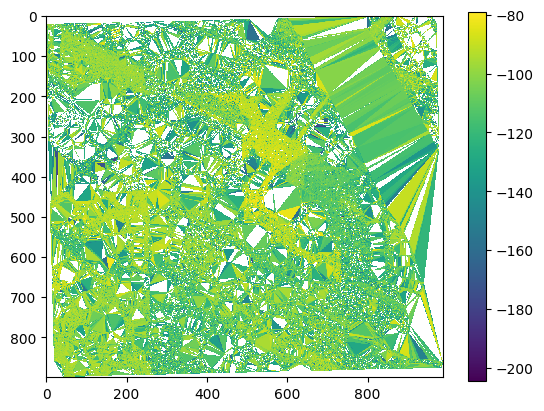

In [5]:
# --------------------------------------------------
# Display the result
# --------------------------------------------------
from matplotlib import pyplot as plt
navie_res = compute_final_weighted_res(color_grid, weight_grid)
print(navie_res[:,:].shape)
db_res = 10 * np.log10(navie_res)
plt.imshow(db_res, interpolation="none")
plt.colorbar()


In [6]:
# multi_process_res = np.load("output_raster.npy")
# print(multi_process_res.shape)
# multi_process_res_db = 10 * np.log10(multi_process_res)
# plt.imshow(multi_process_res, interpolation="none")
# plt.colorbar()

# print("All close: ", np.allclose(color_grid, multi_process_res,equal_nan=True)) 

# # Boolean mask
# # diff_mask = color_grid != multi_process_res

# # Make sure arrays are the same shape
# mask_nan_equal = (np.isnan(color_grid) & np.isnan(multi_process_res))
# diff_mask = (color_grid != multi_process_res) & ~mask_nan_equal


# print("Number of true differences (excluding matching NaNs):", num_diff)
# print("Difference mask:", diff_mask)  # [False  True False  True]
# print("Num of Difference: ",np.sum(color_grid != multi_process_res))
# # Indices where they differ
# diff_indices = np.where(diff_mask)
# print("Differing indices:", diff_indices, len(np.array(diff_indices).flatten()))  # (array([1, 3]),)

# # Show values at those positions
# print("a values:", color_grid[diff_mask])  # [2 4]
# print("b values:", multi_process_res[diff_mask])  # [99 5]


## 2. STRtree Approach


Build the STRtree on the terrain meshes first, then Loop throught each cells, query the STRtree to check if given cell intersect with any triangles. If intersect, loop through all the intersected triangles and record the overlap area and the compute the area weighted path gain(linear).


### Does STRtree help?

**No**(3 vs. 2.5 minutes), since both meshes (terrain and XY plane) are dense. Build STRtree on either of the meshes won't provide much speedup. 
##### When STRtree Does Help
When you have sparse geometry, like:
- Many triangles spread over a large area
- Few triangles overlap a given cell
- When you're doing few expensive spatial queries (e.g., 10,000 queries instead of 800,000)


### Optimizaztion:
- STRtree

In [7]:
%%time

from shapely.strtree import STRtree
from shapely.geometry import Polygon, box
from tqdm import tqdm
import numpy as np

# ---------------------------
# Load path gain values
# ---------------------------

mesh = trimesh.load(PLY_FILE)
triangle_colors = np.load(TRI_PATH_GAIN_FILE)



# ---------------------------
# Project triangles to XY plane and build STRtree
# ---------------------------
triangle_polygons = []
triangle_color_map = {}

for i, face in enumerate(tqdm(mesh.faces)):
    tri_3d = mesh.vertices[face]
    tri_2d = [(x, y) for x, y, z in tri_3d]  # Drop Z
    poly = Polygon(tri_2d)
    if poly.is_valid and poly.area > 0:
        triangle_polygons.append(poly)
    else:
        triangle_polygons.append(None)

# Build spatial index
tree = STRtree(triangle_polygons)

# ---------------------------
# Build 2D grid
# ---------------------------
cell_size = CELL_SIZE
padding = 0.0

min_x, min_y = mesh.bounds[0][:2] - padding
max_x, max_y = mesh.bounds[1][:2] + padding
x_coords = np.arange(min_x, max_x, cell_size)
y_coords = np.arange(min_y, max_y, cell_size)

grid_w, grid_h = len(x_coords), len(y_coords)

color_grid = np.zeros((grid_h, grid_w))   # signal strength accumulator
weight_grid = np.zeros((grid_h, grid_w))  # area accumulator

# ---------------------------
# Area-weighted accumulation using STRtree
# ---------------------------
for yi, y in tqdm(enumerate(y_coords), total=grid_h, desc="Processing grid rows"):
    for xi, x in enumerate(x_coords):
        cell = box(x, y, x + cell_size, y + cell_size)
       
        
        tri_indices = tree.query(cell)

        for idx in tri_indices:
            tri = triangle_polygons[idx]
            area = tri.intersection(cell).area
            if area > 1e-2:
                tri_color = triangle_colors[idx]
                color_grid[yi, xi] += area * tri_color
                weight_grid[yi, xi] += area


Processing grid rows: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [02:12<00:00,  6.77it/s]

CPU times: user 2min 22s, sys: 368 ms, total: 2min 23s
Wall time: 2min 22s


In [8]:
strtree_res = compute_final_weighted_res(color_grid, weight_grid)

print("Results: Navie all close to STRtree: ", np.allclose(navie_res, strtree_res,equal_nan=True))

Results: Navie all close to STRtree:  True


## 3. Multiprocessing + Navie Approach

### Optimizaztion:
- ProcessPoolExecutor + Shared Memory(faces, vertices, x_coords, y_coords, path_gain_values)
- bounding box clipping and filtering.
- Check if intersects first, then calculate the intersection area.

#### Note:
Seems 20 process is a sweet point (18S@10, 11S@20, 8.xS@40+). Still not know the reason why it is 20 (L2/L3/Memory bottleneck?). Have try the following python profilling tool but none of them seems to work with ProcessPoolExecutor.

##### Python Profiling tools Tried
- scalene
- py-spy
- pyinstrument

### HW: 4677
- CPU: 1x Intel® Xeon® Platinum 8470+ Processor (ES, stepping 4)
- NUMA Node: 1
- Memory: 8x 32GB 2R8 4800 RDIMM DDR5

In [9]:
!time numactl --cpunodebind=0 --membind=0 python  2DRadioMap_multiprocess.py \
    --ply_file ../scenes/Boston/mesh/lidar_terrain.ply \
    --color_file  ../scenes/Boston/path_gain_values.npy \
    --cell_size 1.0 \
    --n_jobs 20 \
    --output_file output_raster \
    --batch_size 100

faces_data.shape (340814, 3)
verts.shape (170530, 2)
x_coords.dtype float64
Processing 340814 triangles in 3409 batches using 20 workers...
100%|██████████████████████████████████████| 3409/3409 [00:09<00:00, 355.66it/s]
/home/test/geo2sigmap/examples/2DRadioMap_multiprocess.py:327: RuntimeWarning: invalid value encountered in divide
  final_grid = np.where(weight_grid > 0, color_grid / weight_grid, np.nan)
Output saved to output_raster.npy
/home/test/miniconda3/envs/geo2sigmap/lib/python3.12/multiprocessing/resource_tracker.py:279: UserWarning: resource_tracker: There appear to be 2 leaked shared_memory objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '
numactl --cpunodebind=0 --membind=0 python 2DRadioMap_multiprocess.py      1.  250.67s user 30.91s system 2661% cpu 10.579 total


In [10]:
multi_process_res = np.load("output_raster.npy")
print("Results: Navie all close to STRtree: ", np.allclose(navie_res, multi_process_res,equal_nan=True))

Results: Navie all close to STRtree:  True


## 4_1. Shapely Vectorized API (Shapely v2.x)

3m -> <2m

### Optimization:
- Pre-build cells box
- bounding box clipping and filtering.
- Check if intersects first, then calculate the intersection area.

Using the Shapely vectorized API (which then relies on the GEOS verctorized API) to create/intersect the polygons.


In [11]:
%%time

import numpy as np
from shapely.geometry import Polygon, box
from tqdm import tqdm
import argparse
import os
import trimesh
import shapely

mesh = trimesh.load(PLY_FILE)
triangle_colors = np.load(TRI_PATH_GAIN_FILE)
padding = 0

vertices = mesh.vertices[:,0:2]

cell_size = CELL_SIZE

# Get grid bounding box from mesh bounds
min_x, min_y = mesh.bounds[0][:2] - padding
max_x, max_y = mesh.bounds[1][:2] + padding
x_coords = np.arange(min_x, max_x, cell_size)
y_coords = np.arange(min_y, max_y, cell_size)

grid_w, grid_h = len(x_coords), len(y_coords)

# Output grid (RGB image and weight map)
color_grid = np.zeros((grid_h, grid_w))
weight_grid = np.zeros((grid_h, grid_w))


# Assume x_coords and y_coords are 1D sorted arrays from np.arange
xv, yv = np.meshgrid(x_coords, y_coords)

xv = xv.ravel()
yv = yv.ravel()

# Vectorized box creation for each grid cell
cell_boxes = shapely.box(xv.tolist(), yv.tolist(), (xv + cell_size).tolist(), (yv + cell_size).tolist())

print("cell_boxes size: ",len(cell_boxes))

# --------------------------------------------------
# Area-weighted accumulation of triangle colors
# --------------------------------------------------
for i, face in tqdm(enumerate(mesh.faces), total=len(mesh.faces)):
    tri_2d = vertices[face]
    poly = Polygon(tri_2d)

    if not (poly.is_valid and poly.area > 0):
        continue
    
    tri_color = triangle_colors[i]

    bounds = poly.bounds
            
    
    x_start = np.searchsorted(x_coords, bounds[0], side='right') - 1
    x_end   = np.searchsorted(x_coords, bounds[2], side='left')
    y_start = np.searchsorted(y_coords, bounds[1], side='right') - 1
    y_end   = np.searchsorted(y_coords, bounds[3], side='left')
    for xi in range(x_start, x_end):
        for yi in range(y_start, y_end):
            # cell = box(
            #     x_coords[xi], y_coords[yi],
            #     x_coords[xi] + cell_size, y_coords[yi] + cell_size
            # )
            cell = cell_boxes[yi * grid_w + xi]
            if not poly.intersects(cell):
                continue  # Skip early
            area = poly.intersection(cell).area
            
            # Floating-point instability / division by tiny weight
            # If the overlap_area is very small (e.g., < 1e-6), it acts like a divide-by-zero, 
            #  inflating the result.
            if area > 1e-2:
                color_grid[yi, xi] += area * tri_color
                weight_grid[yi, xi] += area

cell_boxes size:  889200


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340814/340814 [01:51<00:00, 3059.80it/s]

CPU times: user 1min 52s, sys: 580 ms, total: 1min 52s
Wall time: 1min 52s


In [12]:
vectorized_v1_res = compute_final_weighted_res(color_grid, weight_grid)

print("Results: Navie all close to STRtree: ", np.allclose(navie_res, vectorized_v1_res,equal_nan=True))

Results: Navie all close to STRtree:  True


## 4_2. Shapely Vectorized API (Shapely v2.x)

3m -> 1.5m

### Optimization:
- Vectorized: Intersect check
- Vectorized: Pre-build cells box
- bounding box clipping and filtering.
- Check if intersects first, then calculate the intersection area.

Using the Shapely vectorized API (which then relies on the GEOS verctorized API) to create/intersect the polygons.


In [13]:
%%time

import numpy as np
from shapely.geometry import Polygon, box
from tqdm import tqdm
import argparse
import os
import trimesh

mesh = trimesh.load(PLY_FILE)
triangle_colors = np.load(TRI_PATH_GAIN_FILE)
padding = 0

vertices = mesh.vertices[:,0:2]

cell_size = CELL_SIZE

# Get grid bounding box from mesh bounds
min_x, min_y = mesh.bounds[0][:2] - padding
max_x, max_y = mesh.bounds[1][:2] + padding
x_coords = np.arange(min_x, max_x, cell_size)
y_coords = np.arange(min_y, max_y, cell_size)
print("x_coords[:10]",x_coords[:10])
grid_w, grid_h = len(x_coords), len(y_coords)

# Output grid (RGB image and weight map)
color_grid = np.zeros((grid_h, grid_w))
weight_grid = np.zeros((grid_h, grid_w))


# Assume x_coords and y_coords are 1D sorted arrays from np.arange
xv, yv = np.meshgrid(x_coords, y_coords)

xv = xv.ravel()
yv = yv.ravel()
# print(xv[:10])
# Vectorized box creation for each grid cell
cell_boxes = shapely.box(xv.tolist(), yv.tolist(), (xv + cell_size).tolist(), (yv + cell_size).tolist())
# print(cell_boxes[0])


# --------------------------------------------------
# Area-weighted accumulation of triangle colors
# --------------------------------------------------
for i, face in tqdm(enumerate(mesh.faces), total=len(mesh.faces)):
    tri_2d = vertices[face]
    poly = Polygon(tri_2d)

    if not (poly.is_valid and poly.area > 0):
        continue
    
    tri_color = triangle_colors[i]

    bounds = poly.bounds
            
    
    x_start = np.searchsorted(x_coords, bounds[0], side='right') - 1
    x_end   = np.searchsorted(x_coords, bounds[2], side='left')
    y_start = np.searchsorted(y_coords, bounds[1], side='right') - 1
    y_end   = np.searchsorted(y_coords, bounds[3], side='left')
    # print("y_start, y_end", y_start, y_end)
    # raise RuntimeError("Manually stopped execution")
    potencial_cells = []
    potencial_cells_indices = []
    for xi in range(x_start, x_end):
        for yi in range(y_start, y_end):
    #         # cell = box(
    #         #     x_coords[xi], y_coords[yi],
    #         #     x_coords[xi] + cell_size, y_coords[yi] + cell_size
    #         # )
            cell = cell_boxes[yi * grid_w + xi]
            # if not poly.intersects(cell):
            #     continue  # Skip early
            
            potencial_cells.append(cell)
            potencial_cells_indices.append((xi, yi))
    intersects = poly.intersects(potencial_cells)
    filtered_potencial_cells = [d for d, m in zip(potencial_cells, intersects) if m]
    filtered_potencial_cells_indices = [d for d, m in zip(potencial_cells_indices, intersects) if m]

    
    intersections = poly.intersection(filtered_potencial_cells)
    
    for i, intersection in enumerate(intersections):
        area = intersection.area
        if intersection.area > 1e-2:
            xi, yi = filtered_potencial_cells_indices[i]
            color_grid[yi, xi] += area * tri_color
            weight_grid[yi, xi] += area
        

x_coords[:10] [-495.72094727 -494.72094727 -493.72094727 -492.72094727 -491.72094727
 -490.72094727 -489.72094727 -488.72094727 -487.72094727 -486.72094727]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 340814/340814 [01:22<00:00, 4138.66it/s]

CPU times: user 1min 22s, sys: 382 ms, total: 1min 23s
Wall time: 1min 23s


In [14]:
vectorized_v2_res = compute_final_weighted_res(color_grid, weight_grid)

print("Results: Navie all close to STRtree: ", np.allclose(navie_res, vectorized_v2_res,equal_nan=True))

# iff_mask = color_grid != multi_process_res

# # Make sure arrays are the same shape
mask_nan_equal = (np.isnan(navie_res) & np.isnan(vectorized_v2_res))
diff_mask = (navie_res != vectorized_v2_res) & ~mask_nan_equal


#print("Number of true differences (excluding matching NaNs):", num_diff)
print("Difference mask:", diff_mask)  # [False  True False  True]
print("Num of Difference: ",np.sum(navie_res != vectorized_v2_res))
# # Indices where they differ
diff_indices = np.where(diff_mask)
print("Differing indices:", diff_indices, len(np.array(diff_indices).flatten()))  # (array([1, 3]),)

# # Show values at those positions
print("a values:", navie_res[diff_mask])  # [2 4]
print("b values:", vectorized_v2_res[diff_mask])  # [99 5]


Results: Navie all close to STRtree:  True
Difference mask: [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
Num of Difference:  49274
Differing indices: (array([], dtype=int64), array([], dtype=int64)) 0
a values: []
b values: []


## 4_3. Shapely Vectorized API (Shapely v2.x) + ProcessPoolExecutor



### Optimization:
- spawn -> fork
- ProcessPoolExecutor
- Vectorized: Intersect check
- Vectorized: Pre-build cells box
- bounding box clipping and filtering.
- Check if intersects first, then calculate the intersection area.

Using the Shapely vectorized API (which then relies on the GEOS verctorized API) to create/intersect the polygons.


In [15]:
!time numactl --cpunodebind=0 --membind=0 python  2DRadioMap_multiprocess-vectorized.py \
    --ply_file ../scenes/Boston/mesh/lidar_terrain.ply \
    --color_file  ../scenes/Boston/path_gain_values.npy \
    --cell_size 1.0 \
    --n_jobs 20 \
    --output_file output_raster_vectorized \
    --batch_size 100

Processing 340814 triangles in 3409 batches using 20 workers...
/home/test/geo2sigmap/examples/2DRadioMap_multiprocess-vectorized.py:377: RuntimeWarning: invalid value encountered in divide
  final_grid = np.where(weight_grid > 0, color_grid / weight_grid, np.nan)
Output saved to output_raster_vectorized.npy
numactl --cpunodebind=0 --membind=0 python  --ply_file  --color_file   1.0  2  103.02s user 8.47s system 2072% cpu 5.380 total


In [16]:
multi_process_res_vectorized = np.load("output_raster_vectorized.npy")
print("Results: Navie all close to STRtree: ", np.allclose(navie_res, multi_process_res,equal_nan=True))

Results: Navie all close to STRtree:  True
